# Exploração Inicial

Este notebook explora características das mortes ocorridas durante a pandemia de COVID através dos dados presentes na API [*covid-tracking*](https://covidtracking.com/data/api).

A API é acessada pela classe `resources.io.api_manager.ApiManager`.
* A classe é responsável por fazer requests a API, coletar, armazenar os dados em diretórios locais e prover acesso fácil a eles.
* A configuração de instanciamento da classe está no aquivo `./.config/covid-tracking-api.yml`

**OBJETIVOS**

* Dentre os principais objetivos iniciais dessa exploração:
    1. Encontrar atributos relevantes/redundantes para mineração
    2. Desenvolver as transformações mais importantes a serem aplicadas aos dados
    3. Apontar relações e carcterísticas entre os atributos

* Os endpoints da API covid-tracking explorados são:
    * Historic US Values
    * State metadata

Census API: https://api.census.gov/data

endpoint(query): /2019/pep/population?get=NAME,DENSITY,POP&for=STATE:*

Manual: https://www.census.gov/content/dam/Census/data/developers/api-user-guide/api-guide.pdf

In [1]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.tsa.api as tsa
from scipy.stats import norm
plt.style.use('ggplot')

In [2]:
def convert_date_to_index(df):
    df = df.assign(date = df['date'].apply(pd.Period)) \
            .set_index('date').sort_index(ascending=True)
    return df

def filling_period_index(df):
    if not missing_period(df.index):
        return df
    else:
        new_index = pd.period_range(start=df.index[0], end=df.index[-1], freq=df.index.freq)
        return df.reindex(new_index)

def slice_dataframe(df, start, end, step=None):
    slice_obj = slice(start, end, step)
    return df.loc[slice_obj]

def missing_period(period_index):
    full_index = pd.period_range(start=period_index[0], end=period_index[-1], freq=period_index.freq)
    return ~len(full_index) == len(period_index)

def mse(series):
    return series.pow(2).sum().mean()

def get_seasonal_component(series, period, **kwargs):
    stl = tsa.STL(series, period=period, **kwargs).fit()
    return stl.seasonal

In [3]:
def plot_grid(nrows=1, ncols=1):
    width = ncols * 5.5 + 2.5
    height = nrows * 4.5 + (nrows - 1) * 1
    return plt.subplots(nrows, ncols, figsize=(width, height), constrained_layout=True)
    
def plot_autocorrelation(series, nlags=100, ax=None, **fig_kwargs):
    if ax is None:
        fig, ax = plt.subplots(**fig_kwargs)
    else:
        plt.sca(ax)
    
    xs = range(1,nlags+1)
    ys = tsa.acf(series, nlags=nlags-1)
    plt.vlines(xs[::5], 0, ys[::5], color='C0', lw=1)
    plt.hlines(norm.ppf(.975) / len(series)**.5, xs[0], xs[-1], ls=(0,(9,5)), color='k', lw=.8, alpha=.5)
    plt.hlines(norm.ppf(.995)  / len(series)**.5, xs[0], xs[-1], color='k', lw=.8, alpha=.5)
    plt.hlines(-norm.ppf(.975) / len(series)**.5, xs[0], xs[-1], ls=(0,(9,5)), color='k', lw=.8, alpha=.5)
    plt.hlines(-norm.ppf(.995)  / len(series)**.5, xs[0], xs[-1], color='k', lw=.8, alpha=.5)
    plt.ylim(-1.05, 1.05)
    plt.xlabel('Lags')
    plt.ylabel('Autocorrelation')

    return ax

* ## Aquisição dos dados *US Historical*

In [4]:
%run scripts/retrieve-data-nb01.py

Fetching 2 endpoints from COVID-TRACKING
[Feb 16. 14:40] Starting process.

[1/2] Endpoint: STATES-INFO -> Requesting API... Writing content

[2/2] Endpoint: US-HISTORICAL -> Requesting API... Writing content

Fetching files concluded.


In [5]:
us_hist = pd.read_pickle('./data/dataframes/us_historical.pkl') \
    .pipe(convert_date_to_index) \
    .pipe(filling_period_index) \
    .pipe(slice_dataframe, 'jan-2020', 'nov-2020')

slice('jan-2020', 'nov-2020', None)


In [14]:
us_hist

,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,death,recovered,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease
date,,,,,,,,,,,,,,,,
2020-01-13,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
2020-01-14,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
2020-01-15,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
2020-01-16,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
2020-01-17,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-26,56,12903480.0,80385000.0,14856.0,90564.0,547145.0,18019.0,29673.0,5986.0,3153.0,255181.0,NaN,1392,2333,340800,129764
2020-11-27,56,13102354.0,81183256.0,14854.0,89913.0,550563.0,18056.0,29858.0,6028.0,3171.0,256585.0,NaN,1404,3418,798256,198874
2020-11-28,56,13253823.0,81743026.0,14780.0,91762.0,554048.0,18249.0,30109.0,6148.0,3179.0,257828.0,NaN,1243,3485,559770,151469


* ## Analisando NULL

É importante entender como a falta de dados pode comprometer a análise/modelagem.

Antes de pensar em como tratar valores `NULL`, convém nesse caso também entender como eles estão distribuídos. Para os dados da *API Covid-tracking* foram contatos (percentuais) da quantidade de `NULL` em cada campo e onde eles aparecem na série temporal.

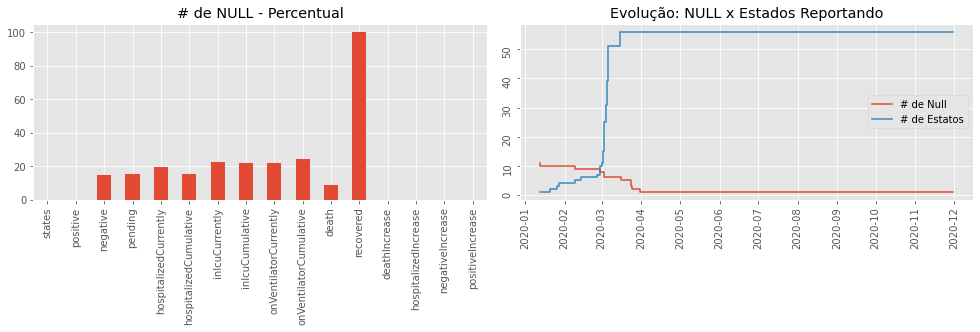

In [73]:
fig, (ax1, ax2) = plot_grid(1, 2)
us_hist.isnull().sum(axis=0).apply(lambda x: x/len(us_hist)*100).plot.bar(title='# de NULL - Percentual', ax=ax1)
us_hist.isnull().sum(axis=1).pipe(lambda s: ax2.step(s.index.to_timestamp(),s.values, label='# de Null'))
us_hist['states'].pipe(lambda s: ax2.step(s.index.to_timestamp(),s.values, label='# de Estatos'))
ax2.legend()
ax2.set_title('Evolução: NULL x Estados Reportando')
ax2.tick_params(rotation=90);

**OBSERVAÇÕES**

* `recovered` é um campo dispensável
* NULL values, fora `recovered`, podem cobrir cerca de 20% da extensão do dataset em cada campo.
    * Esses valores estão, no entando, restritos até o perríodo `2020-04`
* O númro de estados reportante alcança o máximo em meados de março/abril.

* ## Analisando Variáveis Primárias

Os campos de dados obtidos da API são bastante contextualizados entre si.

Em primeiro lugar é essencial observar a *série temporal* dos atributos com a ênfase comparativa na variável de interesse: `death`.

Primeiramente observamos como ela se relaciona com a série das pessoas que testam positivo e negativo para o COVID.

Text(0.5, 1.0, 'Zoom no Número de Mortes')

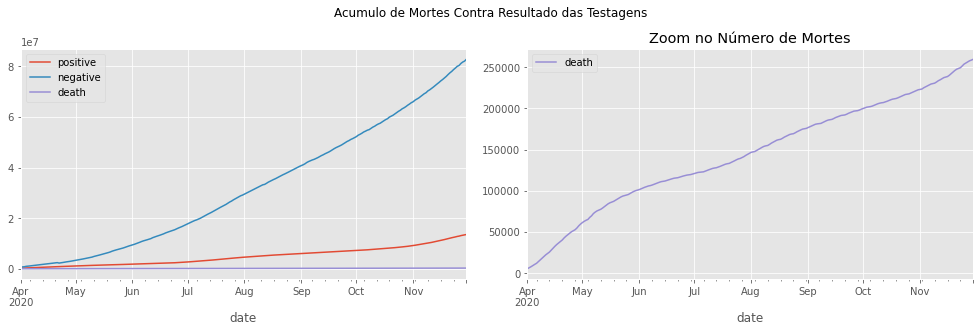

In [420]:
# Descartando a o periodo com poucos estados reportantes / concentração de NULL

us_hist = us_hist.pipe(slice_dataframe, start='apr-2020', end='nov-2020')

fig, (ax1, ax2) = plot_grid(1, 2)
us_hist[['positive', 'negative', 'death']].plot(ax=ax1)
us_hist['death'].plot(ax=ax2, color='C2', label='death', legend=True)
fig.suptitle('Acúmulo de Mortes Contra Resultado das Testagens');
ax2.set_title('Zoom no Número de Mortes')

A API oferece campos com sufixo `Cumulative`, intuitivamente indicam uma quantidade montande (integrando ao longo da série temporal) e outros campos com sufixo `Increase` que indicam um aumento entre 2 registros, o que sugere uma derivação, ou taxa de variação da série temporal. 

A imagem a baixo procura confirmar isso para o atributo `death`.

<AxesSubplot:xlabel='deathDiff', ylabel='deathIncrease'>

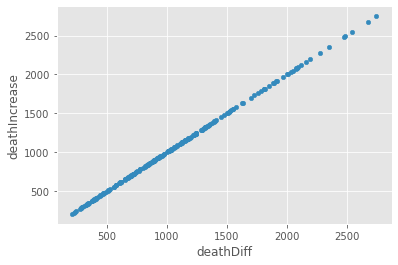

In [231]:
# Comparando diferenciação com o aumento instanTâneo

us_hist.assign(deathDiff = lambda df: df['death'].diff()) \
    .plot.scatter(x='deathDiff', y='deathIncrease')

Em se tratando de fazer previsões no de *forecasting*, trabalhar com taxas de variação tende a ser mais objetivo.
No entanto esse tipo de dado pode estar mais sujeito a ruídos.

Repetindo a mesma análise para as taxas de variação `positiveIncrease`, `negativeIncrease` contra `deathIncrease`.

Text(0.5, 1.0, 'Zoom no Número de Mortes')

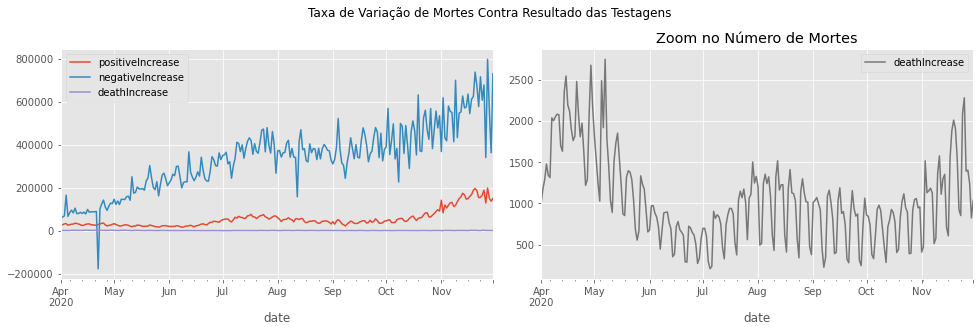

In [422]:
# Visualizando as taxas de variações

fig, (ax1, ax2) = plot_grid(1, 2)
us_hist[['positiveIncrease', 'negativeIncrease', 'deathIncrease']].plot(ax=ax1)
us_hist['deathIncrease'].plot(ax=ax2, color='C3', label='deathIncrease', legend=True)
fig.suptitle('Taxa de Variação de Mortes Contra Resultado das Testagens');
ax2.set_title('Zoom no Número de Mortes')

* As taxas de variações mostram comportamentos mais claros (e mais inconstantes) que as respectivas variáveis cumulativas.
* A taxa de variação de mortes – `deathIncrease` aparenta acompanhar a taxa `positiveIncrease`
    * Taxa de mortes mostra padrões cíclicos, ou mesmo sasonais.

Outro grupo de variáveis relacionadas diretamente a taxa `deathIncrease` são as métricas que indicam as pessoas hospitalizadas. 

Nesse caso há os atributos `hospitalized` e `inIcu` (para casos mais sérios da doença)



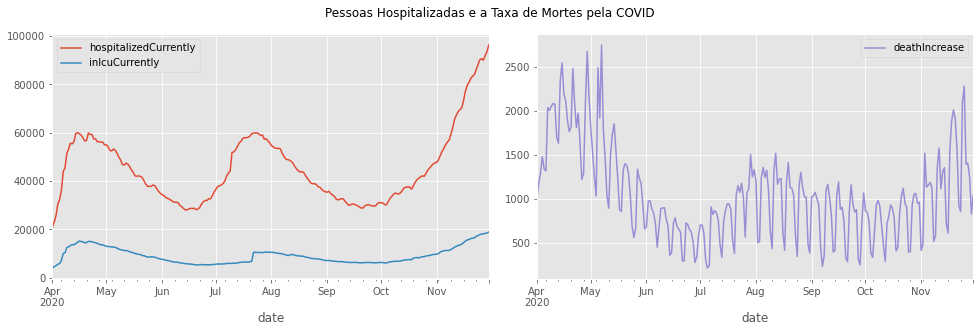

In [423]:
fig, (ax1, ax2) = plot_grid(1, 2)
us_hist[['hospitalizedCurrently', 'inIcuCurrently']].plot(ax=ax1)
us_hist['deathIncrease'].plot(ax=ax2, color='C2', label='deathIncrease', legend=True)
fig.suptitle('Pessoas Hospitalizadas e a Taxa de Mortes pela COVID');

* Essas séries temporais mostram mais "proximidade" com a `deathIncrease`. É evidente os picos entre abril/maio, julho/agosto e uma tendência de crescimento ao final das séries.
    * Contudo as séries também aparentam uma defasagem

* As oscilações na série `deathIncrease` constrastam com a suavidade das outras 2 séries.

* ## Decomposição da Série Temporal `deathIncrease`

É interessante aprofundar a natureza periódica/cíclica da taxa de variação de mortes por questões como:
* Facilita análises posteriores
* Esclarecem mais sobre a natureza do fenômeno

No caso das mortes por covid, não é tão natural que elas ocorram de forma periódica.

O objetico será extrair a componente periódica da série. Para isso será realizada uma decomposição por $\text{LOESS}$ (STL).

1. Invastigamos a peridiocidade da série minimizando  a soma dos quadrados dentro do modelo `stl`

2. Diagnosticamos os resíduos da modelagem

3. Avaliamos a *trend* (tendência da série) e a componente sasonal

Assim buscam-se pelo menos que existe uma valor mínimo que minimize os resíduos, e adicionalmente, espera-se que eles apresentem uma distribuição "equilibrada". Idealmente uma distribuição simétrica, com pouca dispersão (poucos outliers) indicam um modelo saudável.

SSE minimized for period =>  7



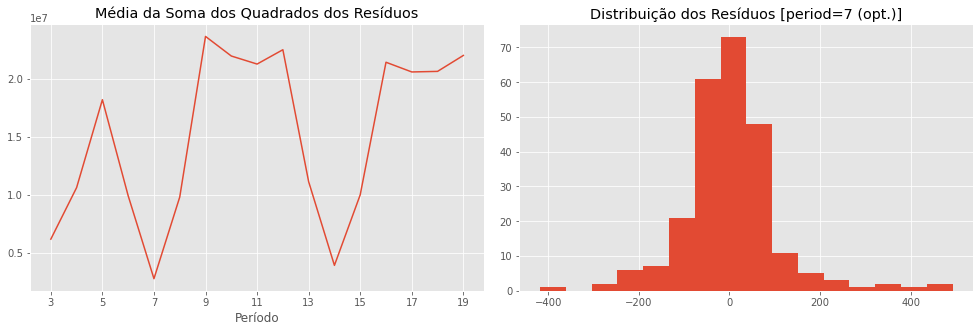

In [437]:
fig, (ax1, ax2) = plot_grid(1, 2)

# Montando experimento para otimização do período da série
test = []
periods = range(3,20)
for period in periods:

    # Fiting do modelo STL
    stl_deaths = tsa.STL(us_hist['deathIncrease'], period=period, seasonal=7).fit()
    
    # guardando resultados
    test.append((period, stl_deaths.resid.pipe(mse), stl_deaths))

# recuperando o valor ótimo
opt_period = min(test, key=lambda x: x[1])
print('SSE minimized for period => ', opt_period[0], end='\n\n')

# Visualizando Resultados
plt.sca(ax1)
xs, ys, _ = zip(*test)
plt.plot(xs, ys)
plt.title('Média da Soma dos Quadrados dos Resíduos')
plt.xlabel('Período')
plt.xticks(list(periods)[::2])

plt.sca(ax2)
plt.title(f'Distribuição dos Resíduos [period={opt_period[0]} (opt.)]')
plt.hist(opt_period[2].resid.values, bins=16)
plt.show()


Pode-se observar que o período sasonal na série é de 7 dias, portanto, um período semanal. 

É interessante essa periodicidade semanal na série temporal. Ela é provavel resultado do processo de coleta e divugação dos dados e **não** há motivos intríndicos à epidemia da COVID que justifiquem esse comportamento. 

Assim, o ideal seria eliminar esse aspecto sem prejudicar a série original. Isso pode ser feito...

1. Recuperando apenas a *trend* pelo modelo STL, assim deixando de lado a parte sasonal. Uma possível vantagem é que assim os resíduos também podem ser opcionamente descartados.
2. Fazendo um *downsampling* da série, saindo da escala "diária" para a escala "semanal".

<AxesSubplot:title={'center':'Taxa de Mortes – Amplitude Efetiva Média'}, xlabel='date'>

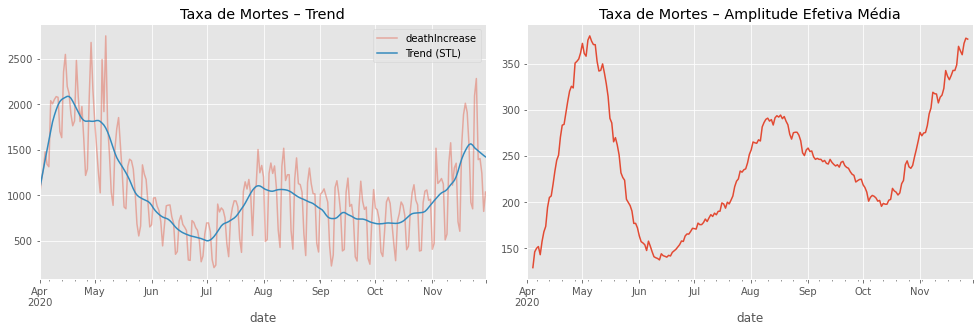

In [438]:
# recuperando o modelo STL otimizado
stl_deaths = opt_period[2]

# Visualizando os resultados da modelagem por LOESS
fig, (ax1, ax2) = plot_grid(1, 2)
stl_deaths.observed.plot(label='deathIncrease', alpha=.4, ax=ax1)
stl_deaths.trend.plot(label='Trend (STL)', ax=ax1, title='Taxa de Mortes – Trend')
ax1.legend()
stl_deaths.seasonal.apply(np.square).apply(np.sqrt).rolling(7, center=True).mean().plot(ax=ax2, title='Taxa de Mortes – Amplitude Efetiva Média')

Pode-se observar que a *trend* obtida do modelo STL é bem aderente a evolução temporal da taxa de mortes, mas é importante confirmar que ela não apresenta nenhuma distorção significante na informação contida na série original. 

Para fazer essa verificação, uma possibilidade é calcular a diferença relativa entre as duas em sua forma integrada, o que é de ~0.2%. Este é um resultado muito bom e confirma o bom *fitting* do modelo STL.

In [439]:
# Relative difference of `deathIncrease` and *unseasoned* `deathIncrease

trend_integrada = stl_deaths.trend.cumsum().sum()
taxa_deathInc_integrada = us_hist['deathIncrease'].cumsum().sum()
rel_diff = abs((trend_integrada - taxa_deathInc_integrada) / taxa_deathInc_integrada)

print(f'Diferença relativa é de {rel_diff*100:.2f}%.')

Diferença relativa é de 0.23%.


Text(0.5, 1.0, 'Death Incease Trend – ACF')

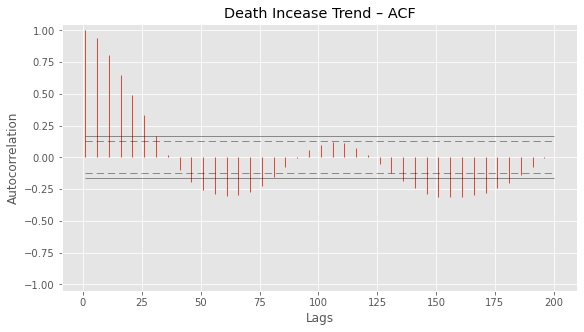

In [440]:
fig, ax = plot_grid()
plot_autocorrelation(stl_deaths.trend, nlags=200, ax=ax)
plt.title('Death Incease Trend – ACF') 

Text(0.5, 1.0, 'Razão Sasonal/Trend')

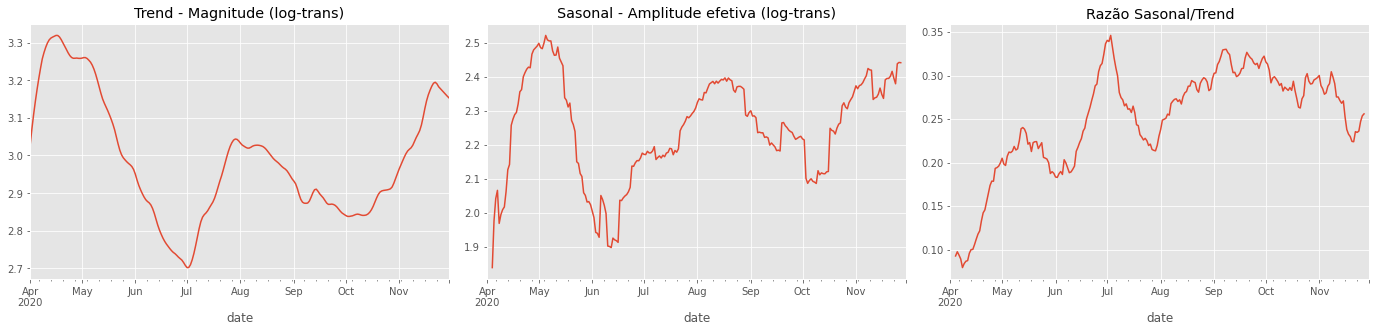

In [441]:
fig, (ax1, ax2, ax3) = plot_grid(1, 3)
stl_deaths.trend.apply(np.log10).plot(ax=ax1)
stl_deaths.seasonal.apply(np.square).apply(np.sqrt).apply(np.log10).rolling(7, center=True).mean().plot(ax=ax2)
(stl_deaths.seasonal.apply(np.square).apply(np.sqrt).rolling(7, center=True).mean() / stl_deaths.trend).plot(ax=ax3)

ax1.set_title('Trend - Magnitude (log-trans)')
ax2.set_title('Sasonal - Amplitude efetiva (log-trans)')
ax3.set_title('Razão Sasonal/Trend')

Text(0.5, 1.0, 'Razão deathIncrease/hospitalizedCurrently')

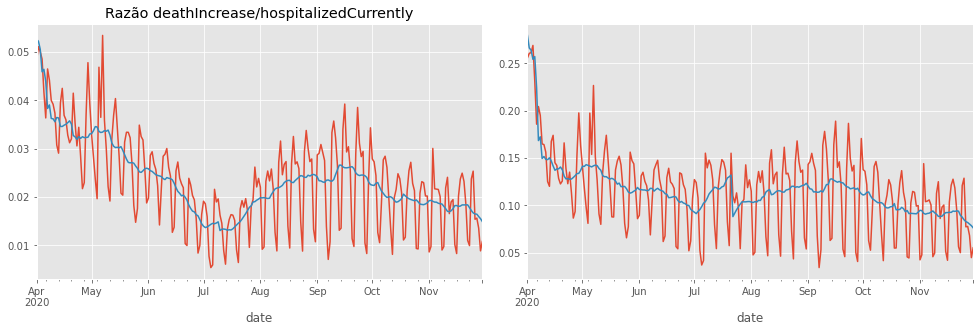

In [248]:
fig, (ax1, ax2) = plot_grid(1, 2)
(us_hist['deathIncrease']/us_hist['hospitalizedCurrently']).dropna().plot(ax=ax1)
(stl_deaths.trend.values/us_hist['hospitalizedCurrently']).dropna().plot(ax=ax1)
(us_hist['deathIncrease']/us_hist['inIcuCurrently']).dropna().plot(ax=ax2)
(stl_deaths.trend.values/us_hist['inIcuCurrently']).dropna().plot(ax=ax2)

ax1.set_title('Razão deathIncrease/hospitalizedCurrently')


* ## Análise da Distribuição Semanal do componente Sasonal

Análise será feita para todos os atributos representando taxas (com sufixo `Increase`)

In [387]:
# filtrando atributos representando taxas 
rates_atts = list(filter(lambda x: 'Inc' in x, us_hist.columns))
len(rates_atts)

4

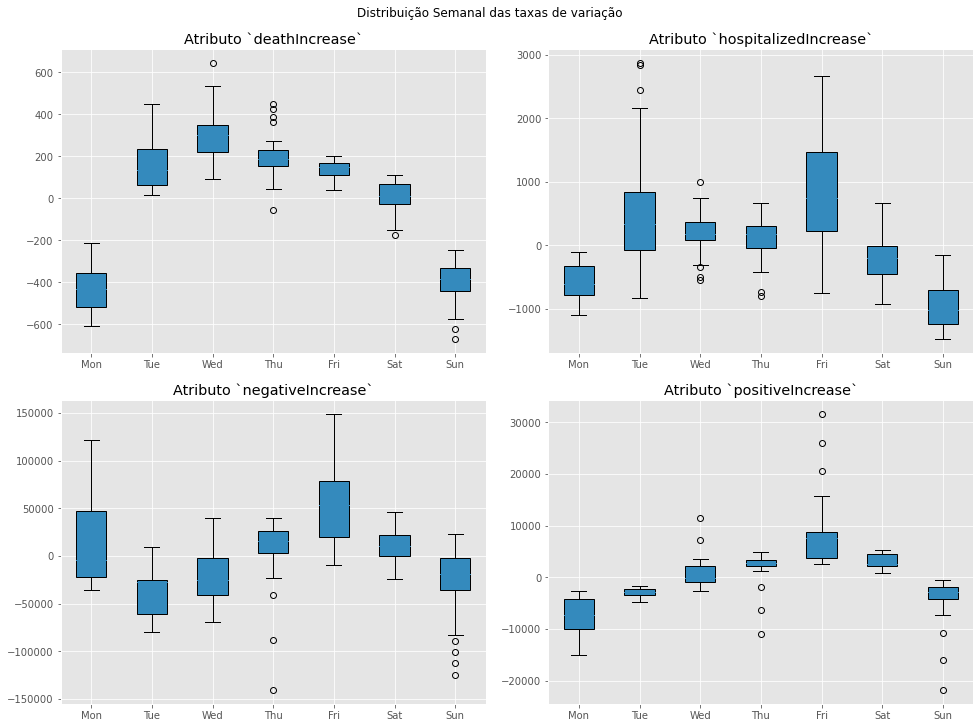

In [414]:
# plotando distribuições 

fig, axs = plot_grid(2, 2)
fig.suptitle('Distribuição Semanal das taxas de variação')
for att, ax in zip(rates_atts, axs.ravel()):
    plt.sca(ax)
    plt.title(f'Atributo `{att}`')
    us_hist[att].dropna() \
        .pipe(get_seasonal_component, period=7, seasonal=9) \
        .groupby(lambda s: s.strftime('%a')).apply(list) \
        .loc[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']] \
        .pipe(lambda s: plt.boxplot(s, labels=s.index, patch_artist=True));

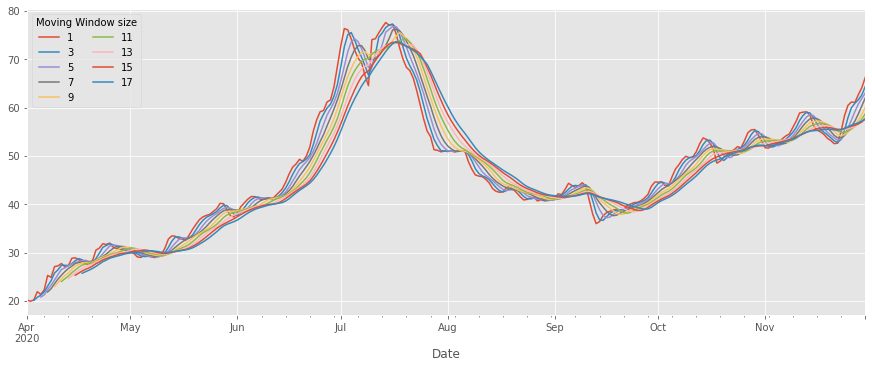

In [416]:
fig, axs = plt.subplots(figsize=(12,5), sharey=True, sharex=True, constrained_layout=True)
for size in range(1, 10):
    (us_hist['hospitalizedCurrently'].rolling(2*size - 1).sum() / stl_deaths.trend.rolling(2*size - 1).sum()).dropna().plot(label=f'{2*size-1}', ax=axs) ; plt.xlabel('Date'); plt.legend(title='Moving Window size', ncol=2)

In [442]:
# fig, ax = plot_grid()
for att in ['inIcuCurrently', 'hospitalizedCurrently', 'hospitalizedIncrease', 'positiveIncrease']:
    series = pd.Series(us_hist[att].values, index= us_hist.index.to_timestamp())
    stl_positives = tsa.STL(series).fit()
    trend = pd.Series(stl_positives.trend.values, index=us_hist.index)
    res= []
    for i in range(0,40):
        pos_series = trend.shift(i).dropna()
        corr = np.corrcoef(pos_series, stl_deaths.trend.reindex(pos_series.index))[0,1]
        res.append((i, corr))

    opt_delay, opt_corrcoef = max(res, key=lambda x: x[1])
    print(f'[{att:.<25}] Linear Corr ({opt_corrcoef:.3f}) maximized for delay => {opt_delay:>02}')
    # ax.plot(*zip(*res));


[inIcuCurrently...........] Linear Corr (0.820) maximized for delay => 00
[hospitalizedCurrently....] Linear Corr (0.616) maximized for delay => 11
[hospitalizedIncrease.....] Linear Corr (0.808) maximized for delay => 10
[positiveIncrease.........] Linear Corr (0.401) maximized for delay => 31
